<a href="https://colab.research.google.com/github/umar51/humanface_emotions_detection/blob/main/googleNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




# **Importing Libraries**

In [ ]:
import pandas as pd
import numpy as np
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Activation
from keras.layers.convolutional import Conv2D, Convolution2D,AveragePooling2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Flatten, Input, concatenate
from keras.optimizers import SGD
from keras.utils import np_utils
import cv2
import matplotlib.pyplot as plt
from PIL import Image

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
import matplotlib
matplotlib.use("Agg")
%matplotlib inline
from sklearn.preprocessing import LabelBinarizer
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD

from google.colab import drive 
drive.mount('/content/gdrive') ##to access files in drive

Mounted at /content/gdrive


# **Data Visualizatiion, Preprocessing and Exploration **

https://www.kaggle.com/code/oykuer/emotion-detection-using-*cnn*





In [ ]:

emotion_data = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/ML Coursework/fer2013.csv")
#dataset shape
emotion_data.shape

In [ ]:
#checking null vslues in dataset
emotion_data.isnull().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

In [ ]:
#exploring data
emotion_data.head()

In [ ]:
#Bar plot for count of images for each emotion 
import plotly.express as px


CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sadness', 'Surprise', 'Neutral'] #swap neutral and surprise places
fig = px.bar(x = CLASS_LABELS,
             y = [list(emotion_data['emotion']).count(i) for i in np.unique(emotion_data['emotion'])] , 
             color = np.unique(emotion_data['emotion']) ,
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

# **fer2013 Importing Data (data in csv file)**
Source: https://www.kaggle.com/datasets/deadskull7/fer2013

In [ ]:
def fer2013Load():
  emotion_data = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/ML Coursework/fer2013.csv")

  #data exploration
  #shuffling dataset
  emotions_data = emotion_data.sample(frac=1)

  X_train = []
  y_train = []
  X_test = []
  y_test = []





  for index, row in emotion_data.iterrows():
      k = row['pixels'].split(" ") #make separate individual at each space in row
      k=np.float_(k) #converting k arrays to float because datasheet provided data in <U format 
      if row['Usage'] == 'Training':# if usage is training
          X_train.append(np.array(k)) #make k array into numpy array and add to X_train
          y_train.append(row['emotion']) #emotion row are labels adding to y_train 
      elif row['Usage'] == 'PublicTest': # usage is for testing
          X_test.append(np.array(k)) #add pixel k array to X_test as np array 
          y_test.append(row['emotion']) #add label to y_test
  X_train = np.array(X_train)
  y_train = np.array(y_train)
  X_test = np.array(X_test)
  y_test = np.array(y_test)

  #input / face pixels
  X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
  X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

##OneHot Encoding 
  #labels/emotions
  y_train= np_utils.to_categorical(y_train, num_classes=7)# converted 1 d array of integers to 7d array of binary numbers
  y_test = np_utils.to_categorical(y_test, num_classes=7)

  return X_train, y_train, X_test, y_test



In [ ]:
#test to train percentage
print('Test data percentage from total data')
print((3589/28709)*100)

(28709, 48, 48, 1)
(3589, 48, 48, 1)
Test data percentage from total data
12.501306210595981


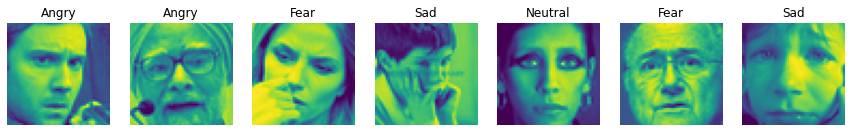

In [ ]:
#Original Dataset Images and labels
X_train, y_train, X_test, y_test = fer2013Load()
plt.figure(figsize=(15,23))
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}
i = 1
for i in range (7):
    img = np.squeeze(X_train[i])
    plt.subplot(1,7,i+1)
    plt.imshow(img)
    index = np.argmax(y_train[i])
    plt.title(label_dict[index])
    plt.axis('off')
    i += 
for i in range (7):
    img = np.squeeze(X_train[i])
    plt.subplot(1,7,i+1)
    plt.imshow(img)
    index = np.argmax(y_train[i])
    plt.title(label_dict[index])
    plt.axis('off')
    i += 1
plt.show()
X_train.

# **GOOGLENET**

Resource https://machinelearningknowledge.ai/googlenet-architecture-implementation-in-keras-with-cifar-10-dataset/

In [ ]:
def conv_module(input,No_of_filters,filtersizeX,filtersizeY,stride,chanDim,padding="same"):
  input = Conv2D(No_of_filters,(filtersizeX,filtersizeY),strides=stride,padding=padding)(input)
  input = BatchNormalization(axis=chanDim)(input)
  input = Activation("relu")(input)
  return input

def inception_module(input,numK1x1,numK3x3,numk5x5,numPoolProj,chanDim):
                                 #Step 1
  conv_1x1 = conv_module(input, numK1x1, 1, 1,(1, 1), chanDim) 
                                 #Step 2
  conv_3x3 = conv_module(input, numK3x3, 3, 3,(1, 1), chanDim)
  conv_5x5 = conv_module(input, numk5x5, 5, 5,(1, 1), chanDim)
                                 #Step 3
  pool_proj = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input)
  pool_proj = Conv2D(numPoolProj, (1, 1), padding='same', activation='relu')(pool_proj)
                                 #Step 4
  input = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=chanDim)
  return input


def downsample_module(input,No_of_filters,chanDim):
  conv_3x3=conv_module(input,No_of_filters,3,3,(2,2),chanDim,padding="valid")
  pool = MaxPooling2D((3,3),strides=(2,2))(input)
  input = concatenate([conv_3x3,pool],axis=chanDim)
  return input

def GoogleNet(width,height,depth,classes):
  inputShape=(height,width,depth)
  chanDim=-1

  # (Step 1) Define the model input
  inputs = Input(shape=inputShape)

  # First CONV module
  x = conv_module(inputs, 96, 3, 3, (1, 1),chanDim)  #3

  # (Step 2) Two Inception modules followed by a downsample module
  x = inception_module(x, 32, 32,32,32,chanDim)
  x = inception_module(x, 32, 48, 48,32,chanDim)
  x = downsample_module(x, 80, chanDim)
  
  # (Step 3) Five Inception modules followed by a downsample module
  x = inception_module(x, 112, 48, 32, 48,chanDim)
  x = inception_module(x, 96, 64, 32,32,chanDim)
  x = inception_module(x, 80, 80, 32,32,chanDim)
  x = inception_module(x, 48, 96, 32,32,chanDim)
  x = inception_module(x, 112, 48, 32, 48,chanDim)
  x = downsample_module(x, 96, chanDim)

  # (Step 4) Two Inception modules followed
  x = inception_module(x, 176, 160,96,96, chanDim)
  x = inception_module(x, 176, 160, 96,96,chanDim)
  
  # Global POOL and dropout
  x = AveragePooling2D((7, 7))(x)
  x = Dropout(0.5)(x)

  # (Step 5) Softmax classifier
  x = Flatten()(x)
  x = Dense(classes)(x)
  x = Activation("softmax")(x)

  # Create the model
  model = Model(inputs, x, name="googlenet")
  return model


# **Calling Model and Dataset**

In [ ]:
X_train, y_train, X_test, y_test = fer2013Load()
model = GoogleNet(48,48,1,7)
model.summary()

In [ ]:
datagen = ImageDataGenerator(  width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               horizontal_flip = True,
                               zoom_range = 0.2)
valgen = ImageDataGenerator(   width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               horizontal_flip = True,
                               zoom_range = 0.2) 

datagen.fit(X_train)
valgen.fit(X_test)

train_generator = datagen.flow(X_train, y_train, batch_size=64)
val_generator = datagen.flow(X_test, y_test, batch_size=64)

# **Model Tunning**

Optimizers: SGD, ADAM, rmsprop (SGD, Adam done)

Learning rates 0.03, 0.01, 0.1

# **Model compiling**

Resource: https://www.kaggle.com/code/oykuer/emotion-detection-using-cnn




In [ ]:
from keras.optimizers import SGD, Adam, RMSprop
model.compile(optimizer=RMSprop(learning_rate= 0.1),loss='categorical_crossentropy',metrics=['accuracy'])


# Training the model/ Model fitting

It was giving some error so Converted Runtime type to GPU and it worked.
Error was:
Conv2DCustomBackpropInputOp only supports NHWC.

In [ ]:

hist=model.fit(X_train,y_train,batch_size=32,epochs=15,verbose=1,validation_data=(X_test, y_test))



Epoch 1/15
898/898 [==============================] - 130s 126ms/step - loss: 7749.6919 - accuracy: 0.2384 - val_loss: 1.8226 - val_accuracy: 0.2494
Epoch 2/15
898/898 [==============================] - 113s 126ms/step - loss: 1.8202 - accuracy: 0.2460 - val_loss: 1.8311 - val_accuracy: 0.2494
Epoch 3/15
898/898 [==============================] - 114s 126ms/step - loss: 1.8203 - accuracy: 0.2450 - val_loss: 1.8253 - val_accuracy: 0.2494
Epoch 4/15
898/898 [==============================] - 113s 126ms/step - loss: 1.8206 - accuracy: 0.2473 - val_loss: 1.8336 - val_accuracy: 0.2494
Epoch 5/15
898/898 [==============================] - 113s 126ms/step - loss: 1.8204 - accuracy: 0.2449 - val_loss: 1.8208 - val_accuracy: 0.2494
Epoch 6/15
898/898 [==============================] - 113s 126ms/step - loss: 5.8289 - accuracy: 0.2440 - val_loss: 1.8559 - val_accuracy: 0.2494
Epoch 7/15
898/898 [==============================] - 113s 126ms/step - loss: 1.8196 - accuracy: 0.2446 - val_loss: 1.823

# **Evaluation and Prediction**

In [ ]:
model.evaluate(X_test, y_test)


113/113 [==============================] - 4s 37ms/step - loss: 1.8343 - accuracy: 0.2494


[1.8343249559402466, 0.24937307834625244]

113/113 [==============================] - 5s 37ms/step


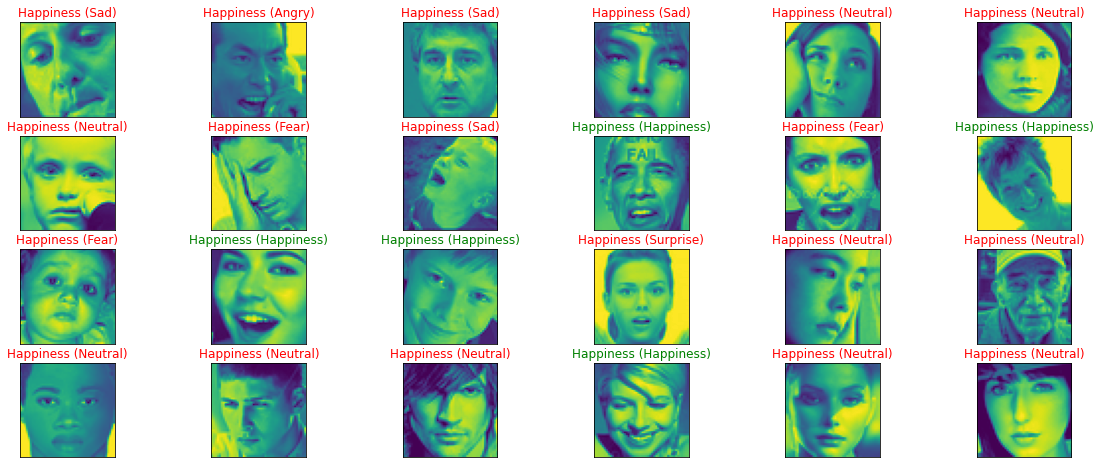

In [ ]:

pred = model.predict(X_test)
y_pred = np.argmax(pred , axis = 1 )
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}

figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[index]))
    predict_index = label_dict[(y_pred[index])]
    true_index = label_dict[np.argmax(y_test,axis=1)[index]]
    
    ax.set_title("{} ({})".format((predict_index), 
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red")) # true label in () and predicted value outside () 
                                  


# **Graph**

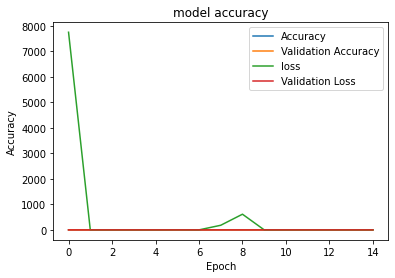

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

# **Confusion Matrix**


https://www.kaggle.com/code/oykuer/emotion-detection-using-cnn?scriptVersionId=104520756&cellId=57


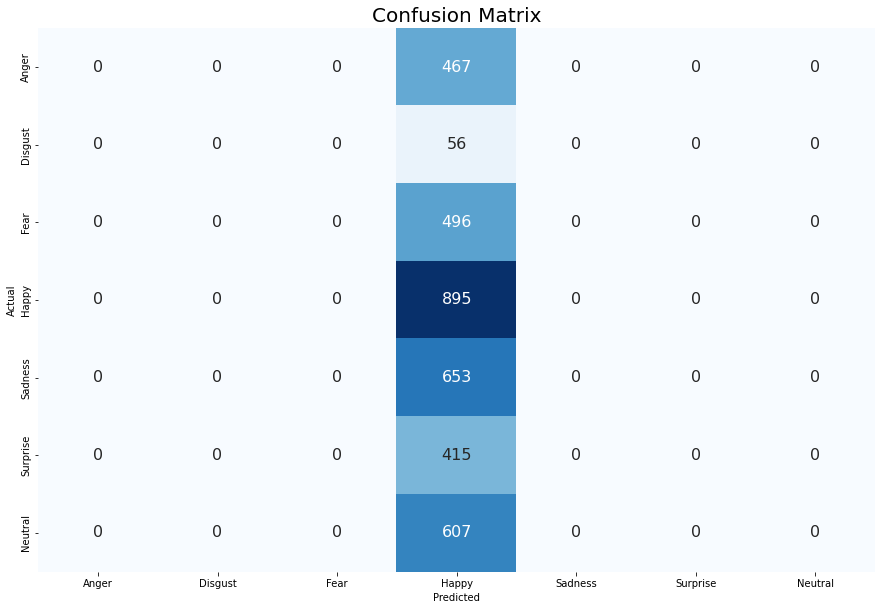

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sadness', 'Surprise', "Neutral"] ##swap

cm_data = confusion_matrix(np.argmax(y_test, axis = 1 ), y_pred)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (15,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')




In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       467
           1      0.000     0.000     0.000        56
           2      0.000     0.000     0.000       496
           3      0.249     1.000     0.399       895
           4      0.000     0.000     0.000       653
           5      0.000     0.000     0.000       415
           6      0.000     0.000     0.000       607

    accuracy                          0.249      3589
   macro avg      0.036     0.143     0.057      3589
weighted avg      0.062     0.249     0.100      3589



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **Saving Model**
[Source](https://medium.com/fintechexplained/how-to-save-trained-machine-learning-models-649c3ad1c018)

In [ ]:
model_json = model.to_json()
with open("/content/gdrive/MyDrive/Colab Notebooks/ML Coursework/googleNetTunning/googleNetmodelRMSpropD0.1.json", "w") as json_file:
  json_file.write(model_json)
model.save_weights("/content/gdrive/MyDrive/Colab Notebooks/ML Coursework/googleNetTunning/googleNetmodelRMSpropD0.1.h5")
print("Saved model to disk")



Saved model to disk


# **Loading Saved Model**

In [ ]:
from keras.models import model_from_json
model = model_from_json(open("/content/gdrive/MyDrive/Colab Notebooks/ML Coursework/googleNetTunning/googleNetmodelRMSpropD0.1.json", "r").read())
model.load_weights('/content/gdrive/MyDrive/Colab Notebooks/ML Coursework/googleNetTunning/googleNetmodelRMSpropD0.1.h5')


# **Test on real images**

# **Capturing and Saving Image**

Resouce: https://colab.research.google.com/notebooks/snippets/advanced_outputs.ipynb#scrollTo=SucxddsPhOmj

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='/content/gdrive/MyDrive/Colab Notebooks/ML Coursework/photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename


from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

# **Saving image**

In [ ]:
from google.colab.patches import cv2_imshow
img = cv2.imread('/content/gdrive/MyDrive/Colab Notebooks/ML Coursework/photo.jpg', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

# **Grey scaling and Dectecting face in image**

In [ ]:
faceCascade = cv2.CascadeClassifier()
grayImg= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + 'haarcascade_frontalface_default.xml') 

faces = face_cascade.detectMultiScale(grayImg)

for (x, y, w, h) in faces: #loop through all of the faces and put rectangles on them
        cv2.rectangle(grayImg, (x, y), (x + w, y + h), (255, 0, 0), 5) #draw rectangles on the faces
        roi_gray = grayImg[y:y+w, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        faceFrame = grayImg[y:y+w, x:x+w]

        print(x,y)
        print(w,h)


cv2_imshow(faceFrame)

cv2_imshow(grayImg)



# **Resizing image**

In [ ]:
grayImg = faceFrame
resizGImg= cv2.resize(grayImg, (48,48))
resizGImg.shape

img_array = [resizGImg]
img_batch = np.expand_dims(img_array, axis=0)
imgF = np.transpose(img_batch, (0,2,3,1))

print(img_batch.shape)
print(imgF.shape)

(1, 1, 48, 48)
(1, 48, 48, 1)


# **Getting Prediciton**

In [ ]:
pred =model.predict(imgF)

y_pred = np.argmax(pred , axis = 1 )
print(y_pred[0])
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}
predict_index = label_dict[(y_pred[0])]

print(predict_index)



1/1 [==============================] - 1s 1s/step
0
Angry
